In [1]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from datetime import datetime, timedelta 

from sklearn.linear_model import LinearRegression

MIN_MINUTE = 9*60+30
MAX_MINUTE = 16*60

In [58]:
df_lst = []
df_tgt = None

for filename in os.listdir('data'):
    sym, _, _ = filename.split('_')    
    df_tmp = pd.read_csv(f'data/{filename}', parse_dates=['Date'], infer_datetime_format=True, index_col='Date')
    
    df_tmp['minute'] = df_tmp.index.hour * 60 + df_tmp.index.minute
    df_tmp = df_tmp[(df_tmp.minute >= MIN_MINUTE) & (df_tmp.minute <= MAX_MINUTE)]
    df_tmp.drop(columns=['minute'], inplace=True)

    dd = (df_tmp.High - df_tmp.Low).values
    tick = np.round(dd[dd > 0].min(), 8)
    
    df_tmp['DP'] = np.round((df_tmp.Close - df_tmp.Open)/tick)
    df_tmp['RET'] = np.log(df_tmp.Close) - np.log(df_tmp.Open)
    df_tmp['VOL'] = (df_tmp.High - df_tmp.Low)/df_tmp.High
    
    
    print(f'load {filename}; Sym = {sym}, tick = {tick}')
    if sym == 'SPY':
        df_tgt = df_tmp
    else:
        df_lst += [df_tmp]

load SPY_20170102_20200805.csv; Sym = SPY, tick = 0.0053
load VGK_20170102_20200805.csv; Sym = VGK, tick = 0.0001
load HYG_20170102_20200828.csv; Sym = HYG, tick = 0.0001
load EWY_20170102_20200805.csv; Sym = EWY, tick = 0.0001
load EWG_20170102_20200805.csv; Sym = EWG, tick = 0.0001
load EWA_20170102_20200805.csv; Sym = EWA, tick = 0.0001
load VIXY_20170102_20200805.csv; Sym = VIXY, tick = 0.0001
load EFA_20170102_20200828.csv; Sym = EFA, tick = 0.0001
load GLD_20170102_20200805.csv; Sym = GLD, tick = 0.0001
load EWU_20170102_20200805.csv; Sym = EWU, tick = 0.0001
load EWZ_20170102_20200805.csv; Sym = EWZ, tick = 0.0001
load FEZ_20170102_20200805.csv; Sym = FEZ, tick = 0.0001
load TLT_20170102_20200805.csv; Sym = TLT, tick = 0.0001


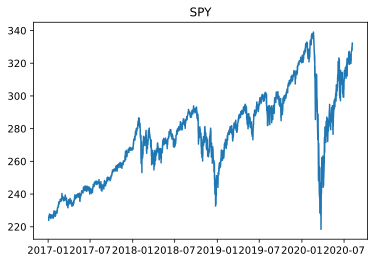

In [82]:
plt.figure()
plt.title('SPY')
plt.plot(df_tgt.Close)

In [60]:
def extract_col(df, col, name=None):
    if name is None:
        name = df.iloc[0].Symbol
    return df[[col]].rename(columns={col: name})

def join_col(df_tgt, df_lst, col, fillna=None):
    df = extract_col(df_tgt, col)
    for df_next in df_lst:
        df = df.join(extract_col(df_next, col), how='left')
        
    if fillna is not None:
        df.fillna(fillna, inplace=True)
    return df

df_return = join_col(df_tgt, df_lst, 'RET')
df_volatility = join_col(df_tgt, df_lst, 'VOL')
df_volume = join_col(df_tgt, df_lst, 'Volume')


In [61]:
#
# Cross Correlations per lag from 0 to 10
#

def get_lag(df, lag, interval=None):
    df_rest = df.drop('SPY', axis=1)
    df_spy  = df[['SPY']]
    index = df_spy.index - timedelta(minutes=lag)
    df_lag = df_spy.set_index(index, drop=True).join(df_rest)
    if interval is not None:
        minutes = df_lag.index.hour * 60 + df_lag.index.minute
        mask = (minutes >= interval[0]) & (minutes <= interval[1])
        df_lag = df_lag.iloc[mask]
    return df_lag
        


corr = {}
for lag in range(10):
    df_lag = get_lag(df_return, lag, (MIN_MINUTE, MAX_MINUTE))
    corr[lag] = df_lag.corr()['SPY']
    
df_corr = pd.DataFrame(corr).transpose().drop('SPY', axis=1)
df_corr

,VGK,HYG,EWY,EWG,EWA,VIXY,EFA,GLD,EWU,EWZ,FEZ,TLT
0,0.482914,0.390561,0.605217,0.030260,0.402661,-0.567351,0.593394,-0.009876,0.419290,0.467168,0.473817,-0.228843
1,0.007672,0.001985,0.006105,0.000904,0.005033,-0.008513,0.006338,-0.001697,0.008441,0.006978,0.006612,-0.002546
2,-0.003307,0.000401,-0.005069,-0.000403,-0.004565,0.004405,-0.004938,0.004949,-0.004411,0.001360,-0.006991,0.010744
3,-0.006457,0.008005,-0.006131,-0.000598,-0.001707,0.003282,-0.002143,-0.000925,-0.005071,-0.003520,-0.003454,0.000332
4,0.001399,0.005099,0.003035,-0.001759,-0.003521,0.002786,0.001747,0.002846,-0.000930,-0.002038,0.008635,-0.003721
5,-0.010281,-0.007594,-0.007094,-0.001729,-0.005741,0.005709,-0.008638,0.001617,-0.007883,-0.003063,-0.007292,0.008642
6,-0.000948,-0.001333,-0.000507,0.000124,0.002233,0.004405,0.000464,-0.004657,0.000238,-0.003909,0.000651,-0.011904
7,0.001021,-0.003342,-0.000285,0.001501,0.000919,0.001976,0.004268,0.003210,-0.000704,0.001125,0.001574,0.008037
8,-0.000381,0.006089,-0.003245,0.002092,-0.003415,-0.000680,0.001149,0.002480,0.000718,0.003022,0.000807,0.006697
9,-0.010276,-0.008685,-0.015965,-0.001400,-0.012326,0.006648,-0.011149,-0.006011,-0.009018,-0.004821,-0.011313,-0.002080


0.002247355186919514


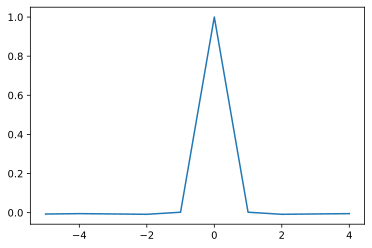

In [62]:
X = range(-5,5)
Y = [df_return.SPY.autocorr(lag) for lag in X]
plt.plot(X, Y)

print(df_return.SPY.autocorr(-1))

According the autocorrelation results, there is no significant positive or negative corrlation for any non zero lag, 
which rules out momentum and mean reversion respectively. 

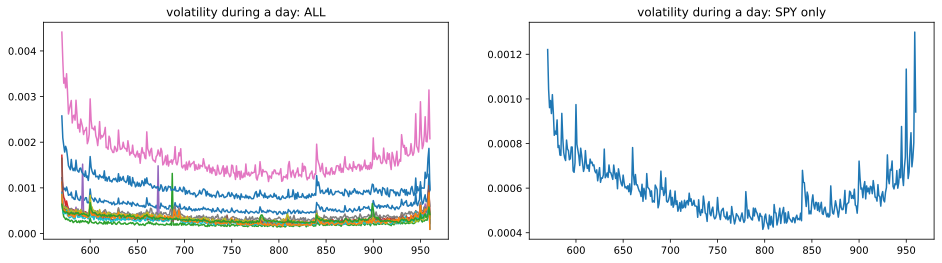

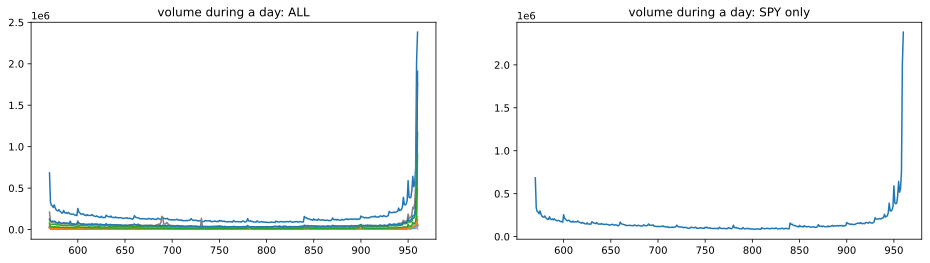

In [63]:

def plot_average_per_minute(df, name):    
    df = df.copy()
    df['minute'] = df.index.hour * 60 + df.index.minute
    avg = df.groupby('minute').mean()
    plt.figure(figsize=(16, 4))
    plt.subplot(1,2,1)
    plt.title(f'{name}: ALL')
    plt.plot(avg)
    plt.subplot(1,2,2)
    plt.title(f'{name}: SPY only')
    plt.plot(avg.SPY)
    plt.show()

plot_average_per_minute(df_volatility, 'volatility during a day')
plot_average_per_minute(df_volume, 'volume during a day')



We see that both volume and volatility (represented by high-low difference) are higher during open and close.
The volume is especialy high on the close.

In [64]:
def plot_average_weekly_over_time(df, name, interval=None):
    df = df.copy()
    
    if interval is not None:
        min_minute, max_minute = interval
        minutes = df.index.minute + df.index.hour * 60
        mask = (minutes >= min_minute) & (minutes <= max_minute)
        df = df.iloc[mask]

    df['year'] = df.index.year
    df['week'] = df.index.isocalendar().week
    avg = df.groupby(by=['year', 'week']).mean()
    avg.reset_index(drop=True, inplace=True)
    
    plt.figure(figsize=(16, 4))
    plt.subplot(1,2,1)
    plt.title(f'{name}: ALL')
    plt.plot(avg)
    plt.subplot(1,2,2)
    plt.title(f'{name}: SPY only')
    plt.plot(avg.SPY)
    plt.show()

MORNING = (9*60 + 30, 10*60)    
EVENING = (15*60 + 30, 16*60)    

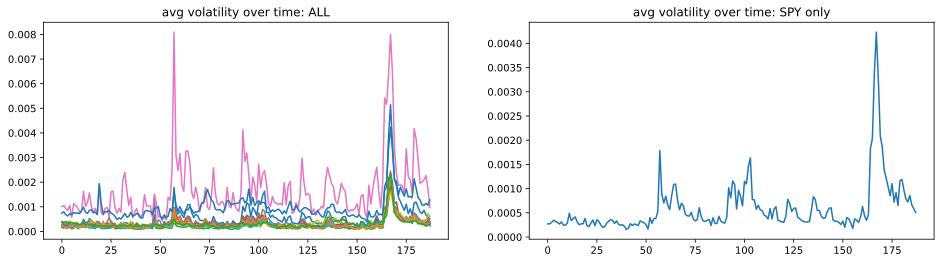

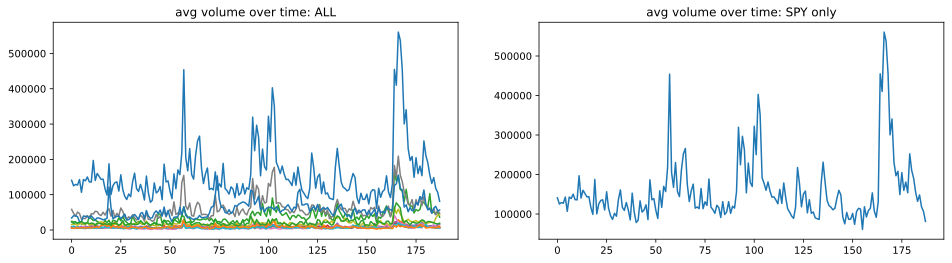

In [65]:
plot_average_weekly_over_time(df_volatility, 'avg volatility over time')
plot_average_weekly_over_time(df_volume, 'avg volume over time')

# plot_average_weekly_over_time(df_volatility, 'avg volatility over time [opening]', MORNING)
# plot_average_weekly_over_time(df_volume, 'avg volume over time [opening]', MORNING)

# plot_average_weekly_over_time(df_volatility, 'avg volatility over time [closing]', EVENING)
# plot_average_weekly_over_time(df_volume, 'avg volume over time [closing]', EVENING)


We see distinct periods where both (volatility and volume) are encreasing significantely. We also see some ses

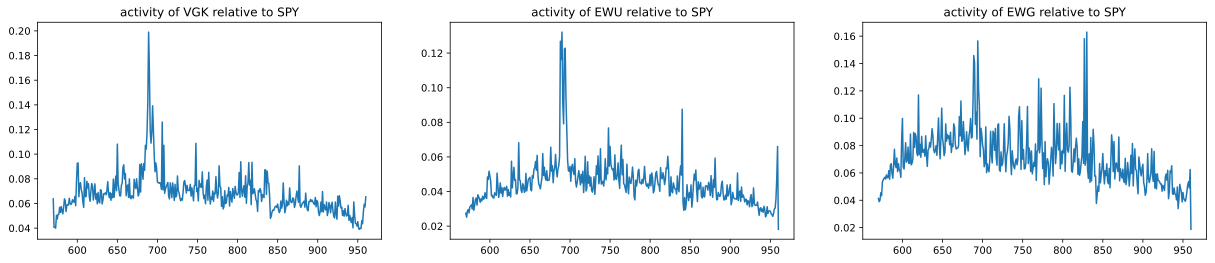

In [66]:
df = df_volume.copy()
df['minute'] = df.index.hour * 60 + df.index.minute
avg = df.groupby('minute').mean()

plt.figure(figsize=(21, 4))
plt.subplot(1,3,1)
plt.title('activity of VGK relative to SPY')
plt.plot(avg.VGK / avg.SPY)

plt.subplot(1,3,2)
plt.title('activity of EWU relative to SPY')
plt.plot(avg.EWU / avg.SPY)

plt.subplot(1,3,3)
plt.title('activity of EWG relative to SPY')
plt.plot(avg.EWG / avg.SPY)


The spike on end of day in europe exchages is visible.

In [87]:
def drop_na(X, Y):
    m = (np.isnan(X).any(axis=1) == False) & (np.isnan(Y) == False)
    return X[m, :], Y[m]

df_lag = get_lag(df_return, 1, (MIN_MINUTE, MAX_MINUTE))

feature_cols = df_lag.columns.values[1:]
target_col = df_lag.columns.values[0]

months = df_lag.index.year * 12 + df_lag.index.month
months = months - months.min()

PNL_PASSIVE = []
PNL_ACTIVE = []
for m in range(3, max(months)):
    df_train = df_lag[(months < m - 1) & (months >= m - 6)]

    X_train = df_train[feature_cols].values
    Y_train = df_train[target_col].values
    X_train, Y_train = drop_na(X_train, Y_train)
    
    df_valid = df_lag[months == m]
    X_valid = df_valid[feature_cols].values
    Y_valid = df_valid[target_col].values
    X_valid, Y_valid = drop_na(X_valid, Y_valid)
    
    lr = LinearRegression().fit(X_train, Y_train)
    pr = lr.predict(X_valid)
    pnl_passive = Y_valid.sum()
    PNL_PASSIVE += [np.exp(pnl_passive)]
    
    pnl_active = Y_valid[pr > 0].sum() - Y_valid[pr < 0].sum()
    PNL_ACTIVE += [np.exp(pnl_active)]
    

<Figure size 432x288 with 0 Axes>

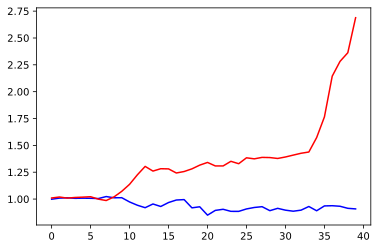

<Figure size 432x288 with 0 Axes>

In [88]:
plt.figure()
plt.plot(np.cumprod(PNL_PASSIVE), 'b')
plt.plot(np.cumprod(PNL_ACTIVE), 'r')
plt.figure()




                          =============================== WHAT ???? ===============================





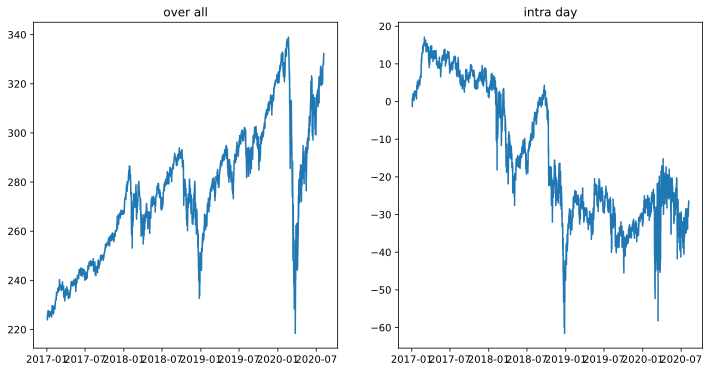

In [98]:
minutes = df_tgt.index .hour * 60 + df_tgt.index.minute
mask = (minutes >= MIN_MINUTE) & (minutes <= MAX_MINUTE)

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('over all')
plt.plot(df_tgt[mask].Open)

plt.subplot(1,2,2)
plt.title('intra day')
plt.plot(np.cumsum(df_tgt[mask].Close - df_tgt[mask].Open))

print('\n\n\n                          =============================== WHAT ???? ===============================\n\n\n')